<a href="https://colab.research.google.com/github/macsrc/mac-ta-lib-python/blob/master/sankhya/sankhya_delivery_v0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Consolidated Code Starts
--------------------------------------------

In [ ]:
########################## Consolidated Programe ################################
# Get today's date in yyyy-mm-dd format
today_date = datetime.today().strftime('%Y%m%d')


tickerStrings = ['GRASIM.NS']         # , 'MSFT', GRASIM.NS, SBIN.NS
tickerfile = '';
for ticker in tickerStrings:
    data = yf.download(ticker, group_by="Ticker", period="1y", interval="1d")
    data['ticker'] = ticker  # add this column because the dataframe doesn't contain a column with the ticker
    data.to_csv(f'ticker_{ticker}_{today_date}.csv')  # ticker_AAPL_yyyymmss.csv for example
    tickerfile = 'ticker'+ '_' + ticker + '_' + today_date + ".csv"
#     print('ticker'+ '_' + ticker + '_' + today_date + ".csv")
    # print(tickerfile)

    ##### step02 - Create Pandas ds
    aapl = pd.read_csv(tickerfile)
    # print(aapl)

    ##### step03 - Add All TA indicator columns

    # OBV - On Balance Volume
    aapl['OBV'] = OBV(aapl['Close'], aapl['Volume'])

    # Accumulation and Distribution line - Chaikin A/D Line
    aapl['AD'] = AD(aapl['High'], aapl['Low'], aapl['Close'], aapl['Volume'])

    # AROON Indicator
    aapl['aroondown'], aapl['aroonup'] = AROON(aapl['High'], aapl['Low'], timeperiod=14)

    # MACD
    aapl['macd'], aapl['macdsignal'], aapl['macdhist'] = MACD(aapl['Close'], fastperiod=12, slowperiod=26, signalperiod=9)

    # ADX Indicator
    aapl['adx']  = ADX(aapl['High'], aapl['Low'], aapl['Close'], timeperiod=14)
    aapl['PLUS_DI'] = PLUS_DI(aapl['High'], aapl['Low'], aapl['Close'], timeperiod=14)
    aapl['MINUS_DI'] = MINUS_DI(aapl['High'], aapl['Low'], aapl['Close'], timeperiod=14)

    # RSI
    aapl['RSI'] = ta.RSI(aapl['Close'],14)

    # Stochastic
    aapl['slowk'], aapl['slowd'] = ta.STOCH(aapl['High'], aapl['Low'], aapl['Close'], fastk_period=14, slowk_period=3,
                                            slowk_matype=0, slowd_period=3, slowd_matype=0)

    print("Step03: ", aapl)

    ########### Step04 - Get Useful Visualizations ####################
    # Approach: 02 - Make all the three indicator groups independent

    # Trend Indicator
    aroon = 0
    arup = 0
    macd = 0
    macdval = 0
    macdsignal = 0
    adx = 0
    plusdi = 0
    minusdi = 0

    # Momentum
    rsi = 0
    stoch = 0

    # Volume
    adv = 0
    obv = 0

    # index range
    start = 0
    end = len(aapl)

    # result csv
    csv_header = ['Datetime', 'OBV', 'A/D', 'Aroon', 'MACD', 'ADX', 'RSI', 'RSI01', 'RSI02', 'Stoch']
    ticker_signal_csv = ticker + '_' + 'signal' + '_' + today_date + '.csv'

    with open(ticker_signal_csv, 'w', encoding='UTF8', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(csv_header)
    # result csv ends

    for i in range (start, end):

    # Checking for Volume indicators
        # OBV
        price_trend = 0  # used by OBV as well as A/D
        obv_trend = 0
        adv_trend = 0


        if((aapl.iloc[i-10]['Close']) != 0):
            price_trend = (aapl.iloc[i]['Close'] - aapl.iloc[i-10]['Close'])/(aapl.iloc[i-10]['Close'])

        if((aapl.iloc[i-10]['OBV']) != 0):
            obv_trend = (aapl.iloc[i]['OBV'] - aapl.iloc[i-10]['OBV'])/(aapl.iloc[i-10]['OBV'])

        if((aapl.iloc[i]['OBV'] > aapl.iloc[i-5]['OBV']) and (aapl.iloc[i]['Close'] > aapl.iloc[i-5]['Close'])):
            obv = 1
        elif((aapl.iloc[i]['OBV'] > aapl.iloc[i-5]['OBV']) and (aapl.iloc[i]['Close'] < aapl.iloc[i-5]['Close'])):
            obv = 36
        elif((aapl.iloc[i]['OBV'] < aapl.iloc[i-5]['OBV']) and (aapl.iloc[i]['Close'] > aapl.iloc[i-5]['Close'])):
            obv = 36
        elif((price_trend > 1.4*obv_trend) or (1.4*price_trend < obv_trend)):
            obv = 36
        else:
            obv = 0

        # A/D
        # -----
        if((aapl.iloc[i-10]['AD']) != 0):
            ad_trend = (aapl.iloc[i]['AD'] - aapl.iloc[i-10]['AD'])/(aapl.iloc[i-10]['AD'])

        if((aapl.iloc[i]['AD'] > aapl.iloc[i-5]['AD']) and (aapl.iloc[i]['Close'] > aapl.iloc[i-5]['Close'])):
            adv = 1
        elif((aapl.iloc[i]['AD'] > aapl.iloc[i-5]['AD']) and (aapl.iloc[i]['Close'] < aapl.iloc[i-5]['Close'])):
            adv = 36
        elif((aapl.iloc[i]['AD'] < aapl.iloc[i-5]['AD']) and (aapl.iloc[i]['Close'] > aapl.iloc[i-5]['Close'])):
            adv = 36
        elif((price_trend > 1.4*ad_trend) or (1.4*price_trend < ad_trend)):
            adv = 36
        else:
            adv = 0

    #  Checking for momentum indicators
        # Aroon Setup
        ar100 = 'N'
        arup = aapl.iloc[i]['aroonup']
        aroon = 0

        for n in range(i-10,i):
            if(aapl.iloc[n]['aroonup'] == 100):
                ar100 = 'Y'
        if((arup > 80) and (ar100 == "Y") ):
            aroon = 1

        # MACD
        macd = 0
        macdval = aapl.iloc[i]['macd']
        macdsignal = aapl.iloc[i]['macdsignal']

        if((macdval >0) and (macdval > macdsignal)):
            macd = 1

        # ADX
        adx = 0

        adxval = aapl.iloc[i]['adx']
        plusdi = aapl.iloc[i]['PLUS_DI']
        minusdi = aapl.iloc[i]['MINUS_DI']

        if((adxval >= 20) and (plusdi > minusdi)):
            adx = 1
        elif((adxval >= 20) and (plusdi < minusdi)):
            adx = -1
        else:
            adx = 0

        ####  Checking for momentum indicators
        # RSI
        if((aapl.iloc[i]['RSI'] > 70) and (aapl.iloc[i]['RSI'] < aapl.iloc[i-1]['RSI'])):
            rsi = -1
        elif((aapl.iloc[i]['RSI'] < 30) and (aapl.iloc[i]['RSI'] > aapl.iloc[i-1]['RSI'])):
            rsi = 1
        else:
            rsi = 0

        # STO - slowk, slowd
        if((aapl.iloc[i]['slowk'] > 80) and (aapl.iloc[i]['slowk'] < aapl.iloc[i]['slowd'])):
            stoch = -1
        elif((aapl.iloc[i]['slowk'] < 30) and (aapl.iloc[i]['slowk'] > aapl.iloc[i]['slowd'])):
            stoch = 1
        else:
            stoch = 0


    # Final status
        if((obv ==1) and (adv==1) and (aroon==1) and (macd >0) and (adx >0) ):

            print(" Step04: ", aapl.iloc[i]['Date'], " OBV:", obv, " A/D:", adv
              ," Aroon:", aroon, " MACD:", macd, " ADX:", adx
              ," RSI:", rsi, " ", aapl.iloc[i]['RSI'], " ", aapl.iloc[i-1]['RSI']
              , " Stoch:", stoch)
            data = [aapl.iloc[i]['Date'], obv, adv, aroon, macd, adx, rsi, aapl.iloc[i]['RSI'], aapl.iloc[i-1]['RSI'], stoch]

            # write results to file
            with open(ticker_signal_csv, 'a', encoding='UTF8', newline='') as f:
                writer = csv.writer(f)
                writer.writerow(data)


######## Step05 - Draw plots ##################
    # Volume
    aapl[['Close']].plot(figsize=(20,6))
    aapl[['OBV', 'AD']].plot(figsize=(20,6))

    # Trend
    aapl[['aroondown','aroonup']].plot(figsize=(20,6))
    aapl[['macd', 'macdsignal']].plot(figsize=(20,6))
    aapl[['adx', 'PLUS_DI', 'MINUS_DI' ]].plot(figsize=(20,6))

    # Momentum
    aapl[['RSI']].plot(figsize=(20,6))
    aapl[['slowk','slowd']].plot(figsize=(20,6))

    plt.show()


### End of Consolidated Code
===============================================================

# Section-01

In [2]:
# print('hello python')
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
import talib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4745    0  4745    0     0   4726      0 --:--:--  0:00:01 --:--:--  4730
100  517k  100  517k    0     0   190k      0  0:00:02  0:00:02 --:--:--  311k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4753    0  4753    0     0  13137      0 --:--:-- --:--:-- --:--:-- 13129
100  392k  100  392k    0     0   196k      0  0:00:02  0:00:02 --:--:--  532k


In [3]:
# imports
import pandas as pd
import pandas_datareader.data as pdr
import talib as ta
import yfinance as yf
import csv

from talib.abstract import *
from talib import MA_Type
from datetime import datetime

import matplotlib.pyplot as plt
plt.style.use('bmh')

In [15]:
# Get today's date in yyyy-mm-dd format
today_date = datetime.today().strftime('%Y%m%d')
# today_date = '20230728'

# ticker list - 'SBIN.NS',	'AXISBANK.NS',	'ONGC.NS',	'IOC.NS',	'BPCL.NS',
#               'HINDALCO.NS',	'HDFCBANK.NS',	'HAL.NS',	'COALINDIA.NS',	'GRASIM.NS'
tickerStrings = ['MSFT']         # , 'MSFT'], GRASIM.NS, SBIN.NS
tickerfile = '';
for ticker in tickerStrings:
    # data = yf.download(ticker, group_by="Ticker", period="1y", interval="1d")
    data = yf.download('AAPL', '2019-1-1','2019-12-27')
    data['ticker'] = ticker  # add this column because the dataframe doesn't contain a column with the ticker
    data.to_csv(f'ticker_{ticker}_{today_date}.csv')  # ticker_AAPL_yyyymmss.csv for example
    tickerfile = 'ticker'+ '_' + ticker + '_' + today_date + ".csv"
#     print('ticker'+ '_' + ticker + '_' + today_date + ".csv")
    print(tickerfile)

aapl = pd.read_csv(tickerfile)
aapl

[*********************100%%**********************]  1 of 1 completed
ticker_MSFT_20230907.csv


,Date,Open,High,Low,Close,Adj Close,Volume,ticker
0,2019-01-02,38.722500,39.712502,38.557499,39.480000,37.943245,148158800,MSFT
1,2019-01-03,35.994999,36.430000,35.500000,35.547501,34.163834,365248800,MSFT
2,2019-01-04,36.132500,37.137501,35.950001,37.064999,35.622265,234428400,MSFT
3,2019-01-07,37.174999,37.207500,36.474998,36.982498,35.542973,219111200,MSFT
4,2019-01-08,37.389999,37.955002,37.130001,37.687500,36.220528,164101200,MSFT
...,...,...,...,...,...,...,...,...
244,2019-12-19,69.875000,70.294998,69.737503,70.004997,68.290939,98369200,MSFT
245,2019-12-20,70.557503,70.662498,69.639999,69.860001,68.149513,275978000,MSFT
246,2019-12-23,70.132500,71.062500,70.092499,71.000000,69.261612,98572000,MSFT
247,2019-12-24,71.172501,71.222504,70.730003,71.067497,69.327438,48478800,MSFT


In [16]:
aapl.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume,ticker
0,2019-01-02,38.722500,39.712502,38.557499,39.480000,37.943245,148158800,MSFT
1,2019-01-03,35.994999,36.430000,35.500000,35.547501,34.163834,365248800,MSFT
2,2019-01-04,36.132500,37.137501,35.950001,37.064999,35.622265,234428400,MSFT
3,2019-01-07,37.174999,37.207500,36.474998,36.982498,35.542973,219111200,MSFT
4,2019-01-08,37.389999,37.955002,37.130001,37.687500,36.220528,164101200,MSFT


## Step 1 - Pre-requisites

#### a.) Use DF rows at or after first 40 mins
#### b.) Update DF with required columns



In [17]:
# Add All indicator columns

# OBV - On Balance Volume
aapl['OBV'] = OBV(aapl['Close'], aapl['Volume'])

# Accumulation and Distribution line - Chaikin A/D Line
aapl['AD'] = AD(aapl['High'], aapl['Low'], aapl['Close'], aapl['Volume'])

# AROON Indicator
aapl['aroondown'], aapl['aroonup'] = AROON(aapl['High'], aapl['Low'], timeperiod=14)

# MACD
aapl['macd'], aapl['macdsignal'], aapl['macdhist'] = MACD(aapl['Close'], fastperiod=12, slowperiod=26, signalperiod=9)

# ADX Indicator
aapl['adx']  = ADX(aapl['High'], aapl['Low'], aapl['Close'], timeperiod=14)
aapl['PLUS_DI'] = PLUS_DI(aapl['High'], aapl['Low'], aapl['Close'], timeperiod=14)
aapl['MINUS_DI'] = MINUS_DI(aapl['High'], aapl['Low'], aapl['Close'], timeperiod=14)

# RSI
aapl['RSI'] = ta.RSI(aapl['Close'],14)

# Stochastic
aapl['slowk'], aapl['slowd'] = ta.STOCH(aapl['High'], aapl['Low'], aapl['Close'], fastk_period=14, slowk_period=3,
                                        slowk_matype=0, slowd_period=3, slowd_matype=0)

In [18]:
# aapl.columns
aapl.size

5229

## Combined Run 02:
#### @05-09-2023


In [19]:
# Approach: 02 - Make all the three indicator groups independent

# Trend Indicator
aroon = 0
arup = 0
macd = 0
macdval = 0
macdsignal = 0
adx = 0
plusdi = 0
minusdi = 0

# Momentum
rsi = 0
stoch = 0

# Volume
adv = 0
obv = 0

# index range
start = 0
end = len(aapl)

# result csv
csv_header = ['Datetime', 'OBV', 'A/D', 'Aroon', 'MACD', 'ADX', 'RSI', 'RSI01', 'RSI02', 'Stoch']
ticker_signal_csv = ticker + '_' + 'signal' + '_' + today_date + '.csv'

with open(ticker_signal_csv, 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(csv_header)
# result csv ends

for i in range (start, end):

# Checking for Volume indicators
    # OBV
    price_trend = 0  # used by OBV as well as A/D
    obv_trend = 0
    adv_trend = 0


    if((aapl.iloc[i-10]['Close']) != 0):
        price_trend = (aapl.iloc[i]['Close'] - aapl.iloc[i-10]['Close'])/(aapl.iloc[i-10]['Close'])

    if((aapl.iloc[i-10]['OBV']) != 0):
        obv_trend = (aapl.iloc[i]['OBV'] - aapl.iloc[i-10]['OBV'])/(aapl.iloc[i-10]['OBV'])

    if((aapl.iloc[i]['OBV'] > aapl.iloc[i-5]['OBV']) and (aapl.iloc[i]['Close'] > aapl.iloc[i-5]['Close'])):
        obv = 1
    elif((aapl.iloc[i]['OBV'] > aapl.iloc[i-5]['OBV']) and (aapl.iloc[i]['Close'] < aapl.iloc[i-5]['Close'])):
        obv = 36
    elif((aapl.iloc[i]['OBV'] < aapl.iloc[i-5]['OBV']) and (aapl.iloc[i]['Close'] > aapl.iloc[i-5]['Close'])):
        obv = 36
    elif((price_trend > 1.4*obv_trend) or (1.4*price_trend < obv_trend)):
        obv = 36
    else:
        obv = 0

    # A/D
    # -----
    if((aapl.iloc[i-10]['AD']) != 0):
        ad_trend = (aapl.iloc[i]['AD'] - aapl.iloc[i-10]['AD'])/(aapl.iloc[i-10]['AD'])

    if((aapl.iloc[i]['AD'] > aapl.iloc[i-5]['AD']) and (aapl.iloc[i]['Close'] > aapl.iloc[i-5]['Close'])):
        adv = 1
    elif((aapl.iloc[i]['AD'] > aapl.iloc[i-5]['AD']) and (aapl.iloc[i]['Close'] < aapl.iloc[i-5]['Close'])):
        adv = 36
    elif((aapl.iloc[i]['AD'] < aapl.iloc[i-5]['AD']) and (aapl.iloc[i]['Close'] > aapl.iloc[i-5]['Close'])):
        adv = 36
    elif((price_trend > 1.4*ad_trend) or (1.4*price_trend < ad_trend)):
        adv = 36
    else:
        adv = 0

#  Checking for momentum indicators
    # Aroon Setup
    ar100 = 'N'
    arup = aapl.iloc[i]['aroonup']
    aroon = 0

    for n in range(i-10,i):
        if(aapl.iloc[n]['aroonup'] == 100):
            ar100 = 'Y'
    if((arup > 80) and (ar100 == "Y") ):
        aroon = 1

    # MACD
    macd = 0
    macdval = aapl.iloc[i]['macd']
    macdsignal = aapl.iloc[i]['macdsignal']

    if((macdval >0) and (macdval > macdsignal)):
        macd = 1

    # ADX
    adx = 0

    adxval = aapl.iloc[i]['adx']
    plusdi = aapl.iloc[i]['PLUS_DI']
    minusdi = aapl.iloc[i]['MINUS_DI']

    if((adxval >= 20) and (plusdi > minusdi)):
        adx = 1
    elif((adxval >= 20) and (plusdi < minusdi)):
        adx = -1
    else:
        adx = 0

    ####  Checking for momentum indicators
    # RSI
    if((aapl.iloc[i]['RSI'] > 70) and (aapl.iloc[i]['RSI'] < aapl.iloc[i-1]['RSI'])):
        rsi = -1
    elif((aapl.iloc[i]['RSI'] < 30) and (aapl.iloc[i]['RSI'] > aapl.iloc[i-1]['RSI'])):
        rsi = 1
    else:
        rsi = 0

    # STO - slowk, slowd
    if((aapl.iloc[i]['slowk'] > 80) and (aapl.iloc[i]['slowk'] < aapl.iloc[i]['slowd'])):
        stoch = -1
    elif((aapl.iloc[i]['slowk'] < 30) and (aapl.iloc[i]['slowk'] > aapl.iloc[i]['slowd'])):
        stoch = 1
    else:
        stoch = 0


# Final status
    if((obv ==1) and (adv==1) and (aroon==1) and (macd >0) and (adx >0) ):

        print(aapl.iloc[i]['Date'], " OBV:", obv, " A/D:", adv
          ," Aroon:", aroon, " MACD:", macd, " ADX:", adx
          ," RSI:", rsi, " ", aapl.iloc[i]['RSI'], " ", aapl.iloc[i-1]['RSI']
          , " Stoch:", stoch)
        data = [aapl.iloc[i]['Date'], obv, adv, aroon, macd, adx, rsi, aapl.iloc[i]['RSI'], aapl.iloc[i-1]['RSI'], stoch]

        # write results to file
        with open(ticker_signal_csv, 'a', encoding='UTF8', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(data)

#         print(aapl.iloc[i])
#         print(aapl.loc[aapl['Datetime'] == aapl.iloc[i]['Datetime']])


2019-03-13  OBV: 1  A/D: 1  Aroon: 1  MACD: 1  ADX: 1  RSI: 0   70.23881615748958   69.21105371839575  Stoch: 0
2019-03-14  OBV: 1  A/D: 1  Aroon: 1  MACD: 1  ADX: 1  RSI: 0   72.71542362571559   70.23881615748958  Stoch: 0
2019-03-15  OBV: 1  A/D: 1  Aroon: 1  MACD: 1  ADX: 1  RSI: 0   75.33113385108305   72.71542362571559  Stoch: 0
2019-03-18  OBV: 1  A/D: 1  Aroon: 1  MACD: 1  ADX: 1  RSI: 0   77.20227485226248   75.33113385108305  Stoch: 0
2019-03-19  OBV: 1  A/D: 1  Aroon: 1  MACD: 1  ADX: 1  RSI: -1   72.55456579826868   77.20227485226248  Stoch: -1
2019-03-20  OBV: 1  A/D: 1  Aroon: 1  MACD: 1  ADX: 1  RSI: 0   74.37219763640104   72.55456579826868  Stoch: -1
2019-03-21  OBV: 1  A/D: 1  Aroon: 1  MACD: 1  ADX: 1  RSI: 0   80.33508328003059   74.37219763640104  Stoch: -1
2019-03-22  OBV: 1  A/D: 1  Aroon: 1  MACD: 1  ADX: 1  RSI: -1   70.09579786372285   80.33508328003059  Stoch: -1
2019-04-09  OBV: 1  A/D: 1  Aroon: 1  MACD: 1  ADX: 1  RSI: -1   74.54361311833951   76.3525551282

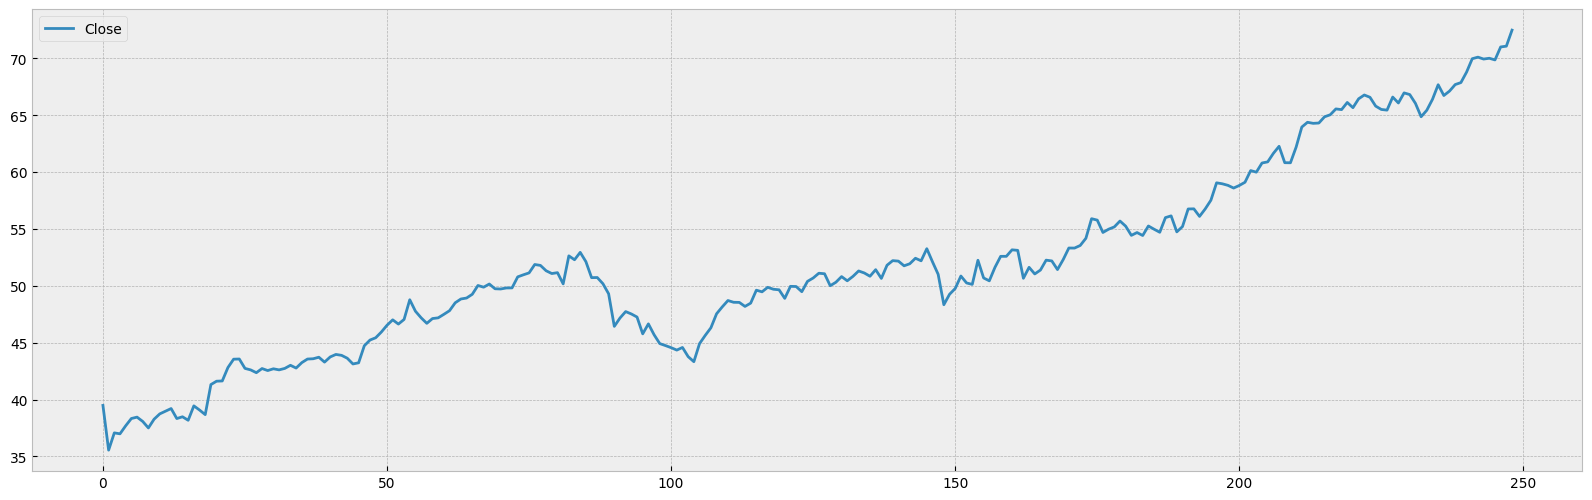

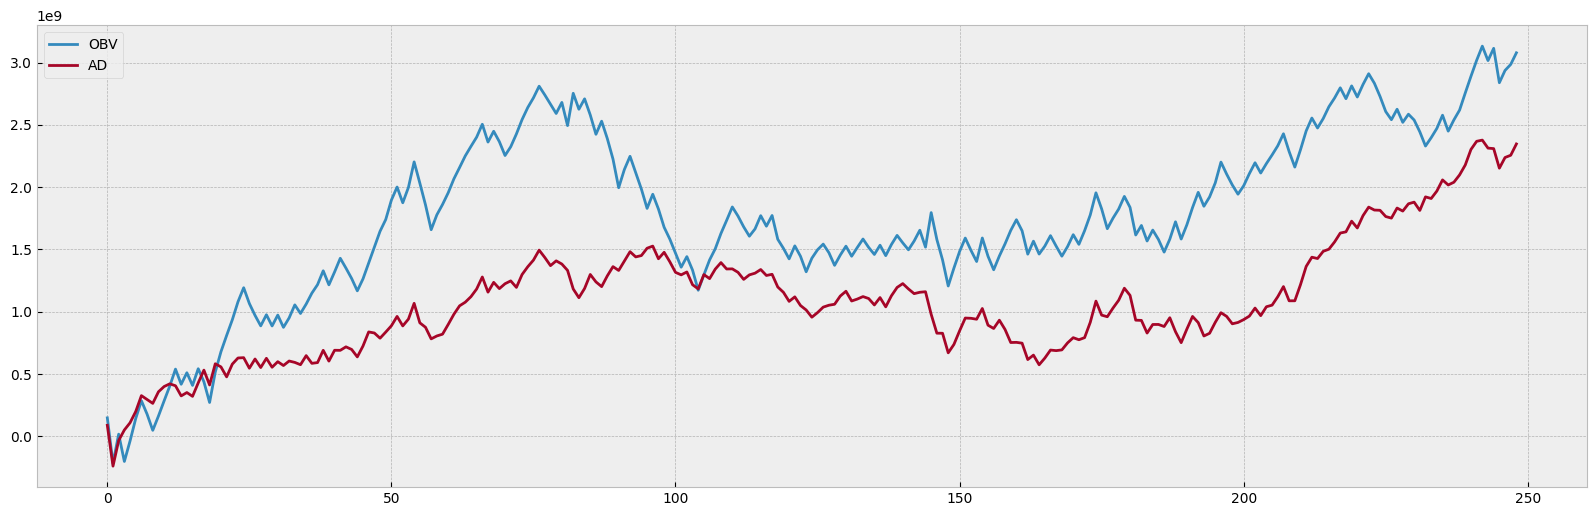

In [20]:
aapl[['Close']].plot(figsize=(20,6))
aapl[['OBV', 'AD']].plot(figsize=(20,6))
# aapl[['AD']].plot(figsize=(20,6))

plt.show()

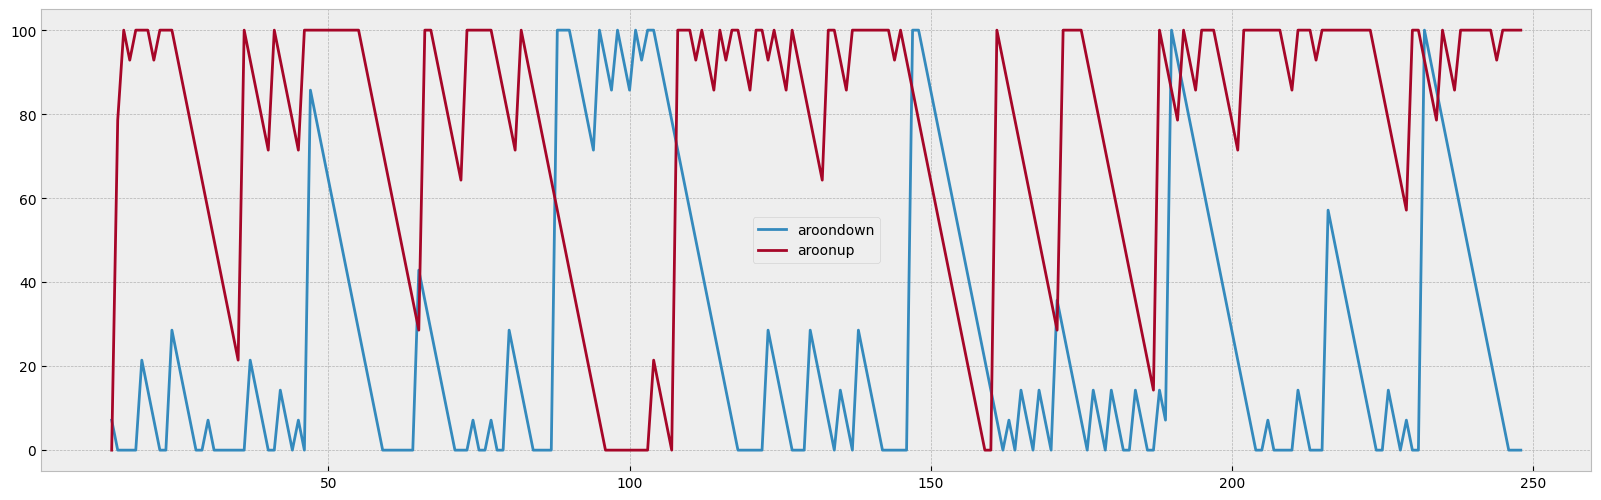

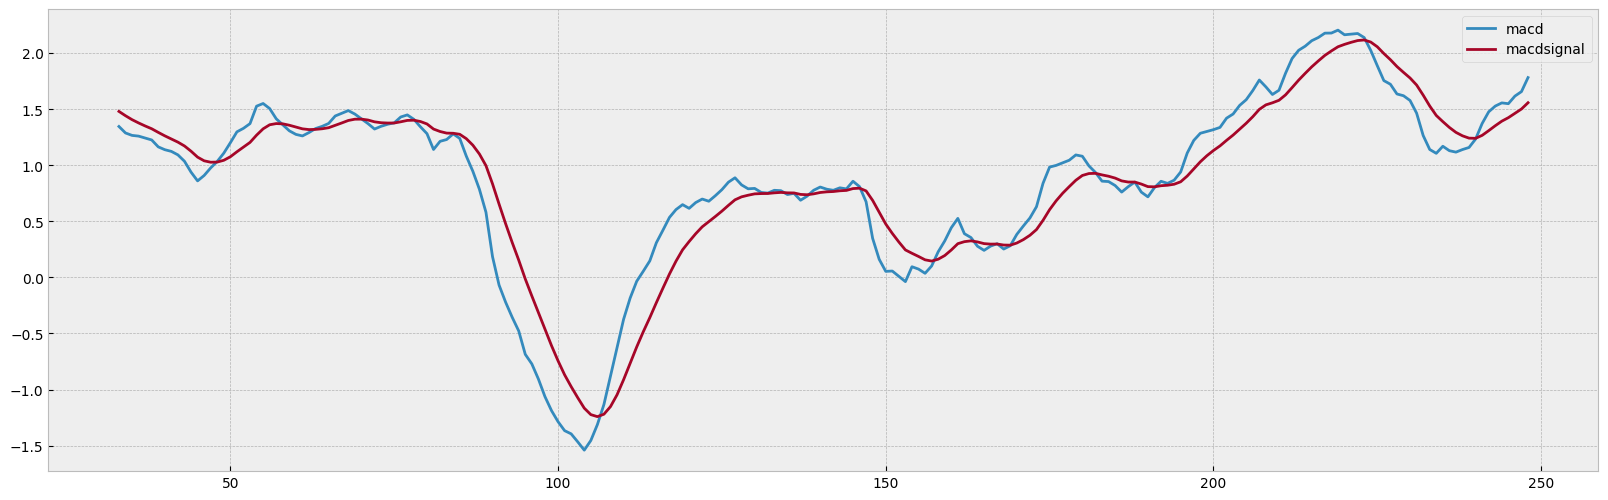

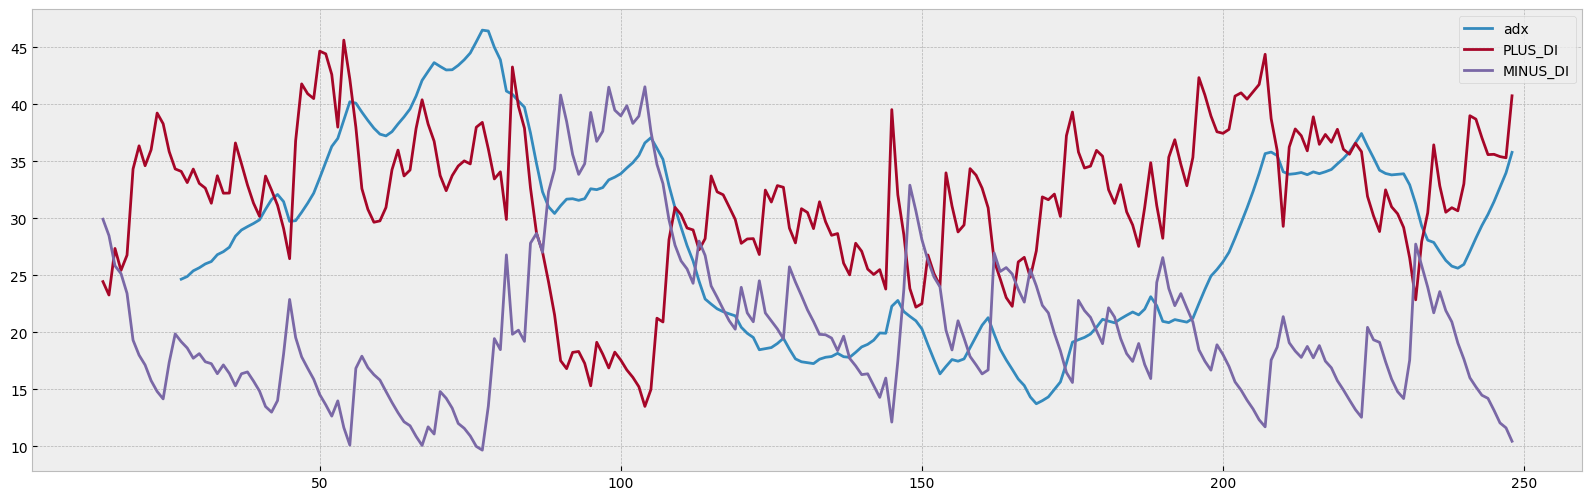

In [21]:
aapl[['aroondown','aroonup']].plot(figsize=(20,6))
aapl[['macd', 'macdsignal']].plot(figsize=(20,6))
aapl[['adx', 'PLUS_DI', 'MINUS_DI' ]].plot(figsize=(20,6))
plt.show()

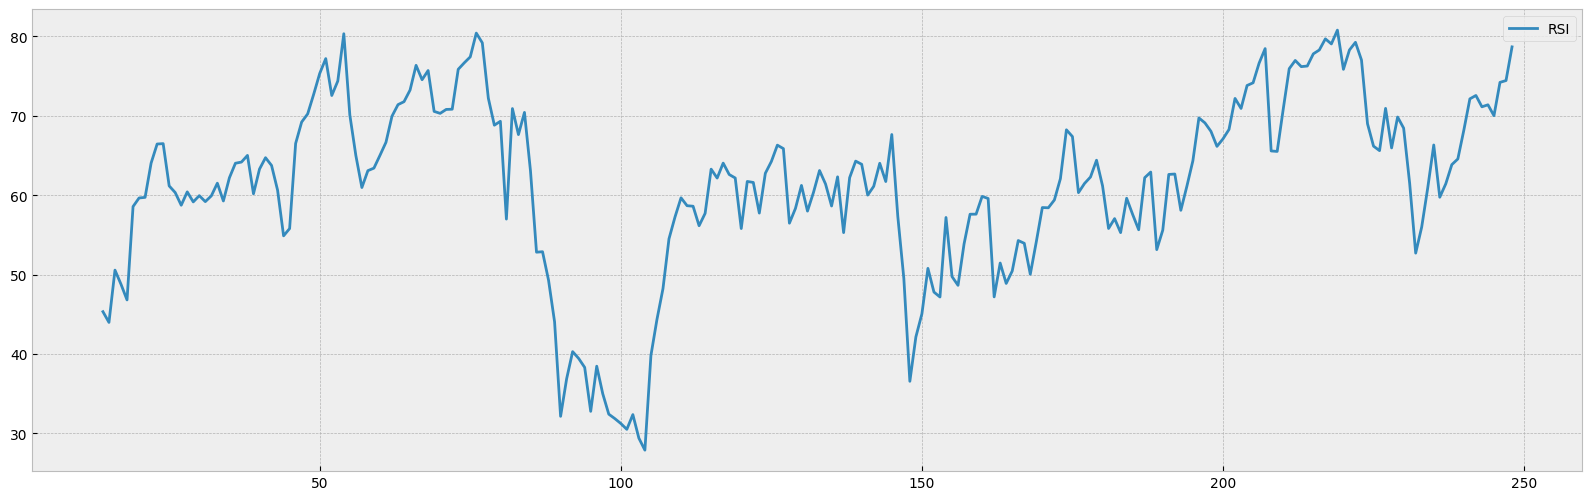

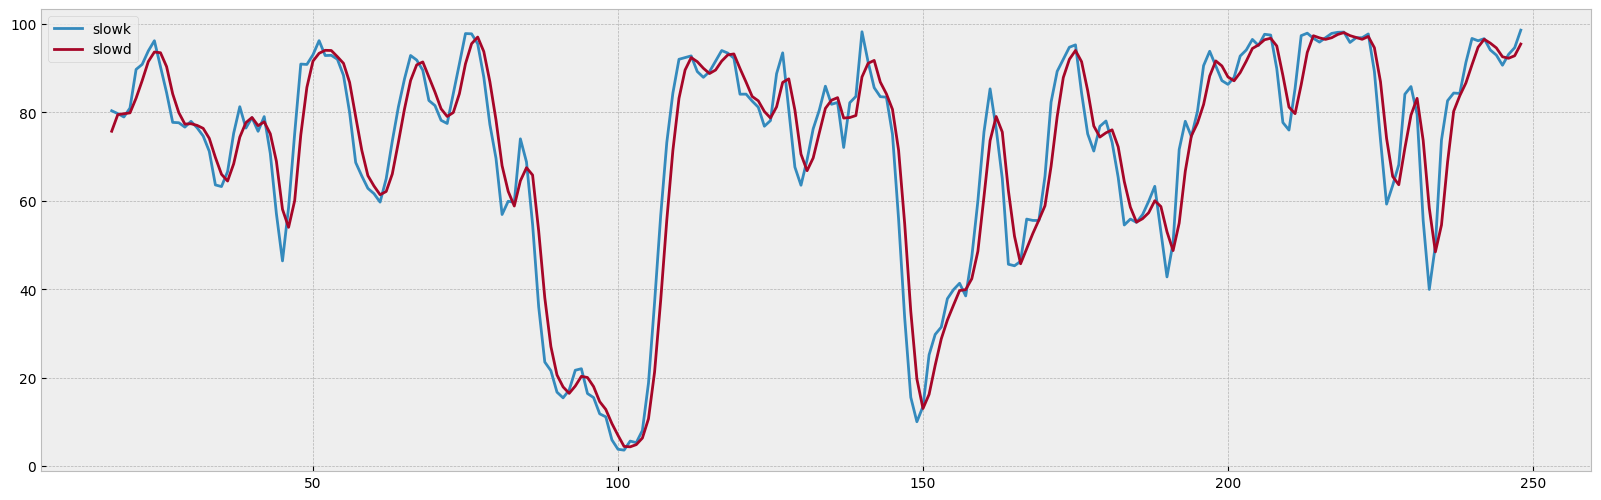

In [22]:
aapl[['RSI']].plot(figsize=(20,6))
aapl[['slowk','slowd']].plot(figsize=(20,6))   #STO - slowk, slowd
plt.show()